<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

import matplotlib.pyplot as plt

# Introduce yourself

Put your team name and team-members' names below

Команда - Переобученный дуршлаг <br>
Участники:
<ul style="margin-top: 2px;">
 <li>Кукава Ираклий</li>
 <li>Михайленко Денис</li>
 <li>Зиганшин Марат</li>
</ul>

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

Below you will find some desirable stages of your report.

# Data Loading

In [2]:
data = pd.read_csv('./data/train.tsv', sep = '\t', index_col=0)

In [3]:
data.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

In [4]:
datadict = pd.DataFrame(data.dtypes)
datadict = datadict.rename(columns={0:'DataType'})
datadict['MissingVal'] = data.isnull().sum() + data.isna().sum()
datadict['Count'] = data.count()
datadict['Unique'] = data.nunique()
datadict

,DataType,MissingVal,Count,Unique
category_id,int64,0,351281,24
city,object,0,351281,2299
date_created,object,0,351281,289
delivery_available,bool,0,351281,2
desc_text,object,0,351281,333976
img_num,int64,0,351281,20
lat,float64,0,351281,74798
long,float64,0,351281,109704
name_text,object,0,351281,212239
owner_id,object,0,351281,305336


In [5]:
good_words = ['недорог', 'бесплат', 'подарок', 'нов', 'недорого', 'идеал']

def words_count(text):
    text_splitted = text.split(' ')
    return len(text_splitted)

def good_words_count(text):
    words = text.split(' ')
    good_words_counter = 0
    for word in words:
        for check_word in good_words:
            if word.startswith(check_word):
                good_words_counter += 1
    return np.sqrt(good_words_counter)
 
feature_desc_text = data['desc_text'].values
cols8 = np.array([words_count(t) for t in feature_desc_text])
cols9 = np.array([good_words_count(t) for t in feature_desc_text])
 
col8 = pd.DataFrame({"words_count": cols8})
col9 = pd.DataFrame({"good_words": cols9})
 
data = data.join(col8)
data = data.join(col9)
 
data = data.drop(['desc_text'], axis=1)
 
data['words_count'] = data['words_count'].fillna(0)
data['good_words'] = data['good_words'].fillna(0)

In [6]:
cat_features = []
cat_features_dict = {}

from collections import defaultdict, Counter
def target_encoding(features, targets):
    values = defaultdict(int)
    counts = Counter()
    for val, target in zip(features, targets):
        values[val] += target
        counts[val] += 1
    
    mean_values = dict()
    for val in values:
        mean_values[val] = values[val] / counts[val]
    
    return mean_values

def preprocess_cat_features(data, cat_features, target):
    cat_features_dict = dict()
    for feature in cat_features:
        cat_features_dict[feature] = target_encoding(data[feature].values, data[target].values)
    return cat_features_dict

def my_round(x):
    return round(x*4)/4

def find_middle(d, q):
    count = 0
    tmp = 0
    for ind, val in enumerate(d):
        if val == q:
            tmp += ind
            count += 1
    tmp /= count
    tmp = round(tmp)
    return tmp

def preprocess_data(data, to_submit=False):
    
#     data = data.drop(['owner_id', 'product_id', 'desc_text'], axis=1) 
    data = data.drop(['owner_id', 'product_id'], axis=1) 
    
    # Normilize lat long
    data['lat']  = (data['lat']  - data['lat'].min())  / (data['lat'].max() - data['lat'].min())
    data['long'] = (data['long'] - data['long'].min()) / (data['long'].max() - data['long'].min())

    data['lat']=round(data['lat'], 1)
    data['long']=my_round(data['long'])

    # Избавляемся от огромных значений price
        
    sorted_price = data.sort_values(by=['price'])
    q = sorted_price['price'].quantile(.97)
    print('q', q)
    middle = find_middle(sorted_price['price'], q)
    print('middle', middle)
    print('middle val', sorted_price['price'].values[middle])

    price_without_tail = sorted_price[:middle]
    print('wt mean', price_without_tail['price'].mean())
    price_without_tail['price'].describe()

    data = price_without_tail

    one_hot = pd.get_dummies(data['sold_mode'], prefix='sold_mode')
    data = data.drop('sold_mode',axis = 1)
    data = data.join(one_hot)

    one_hot = pd.get_dummies(data['product_type'], prefix='product_type')
    data = data.drop('product_type',axis = 1)
    data = data.join(one_hot)

    one_hot = pd.get_dummies(data['delivery_available'], prefix='delivery_available')
    data = data.drop('delivery_available',axis = 1)
    data = data.join(one_hot)

    one_hot = pd.get_dummies(data['payment_available'], prefix='payment_available')
    data = data.drop('payment_available',axis = 1)
    data = data.join(one_hot)

    #use real features
    X = data[['price', 'delivery_available_True', 'payment_available_False', 'payment_available_True', 'img_num', 'lat', 'long']].values
    if not to_submit:
        y = data['sold_fast']

    cat_features = ['category_id', 'city', 'region',]
    
    if not to_submit:
        cat_features_dict = preprocess_cat_features(data, cat_features, 'sold_fast')

        for feature in cat_features:
            res = [0] * len(data)
            for i, val in enumerate(data[feature].values):
                res[i] = cat_features_dict[feature][val]
            X = np.c_[X, np.array(res)]
        
        return (data, X, y)
    
    else:
        return (data)

In [7]:
data, X, y = preprocess_data(data)

q 45000.0
middle 340720
middle val 45000.0
wt mean 3518.161088430383


In [8]:
data.head()

,category_id,city,date_created,img_num,lat,long,name_text,price,properties,region,...,words_count,good_words,sold_mode_1,sold_mode_2,product_type_1,product_type_5,delivery_available_False,delivery_available_True,payment_available_False,payment_available_True
479405,9,Орел,2018-01-30,2,0.4,0.00,Два пакета вещей,0.0,[],Орловская область,...,0.0,0.0,1,0,1,0,1,0,1,0
168653,9,Удельная,2018-05-07,2,0.5,0.25,Футболка adidas,0.0,"[{'slug_id': 'zhenskaya_odezhda_razmer', 'slug...",Московская область,...,23.0,0.0,1,0,1,0,1,0,1,0
426968,100,Москва,2018-05-09,4,0.5,0.25,Букет,0.0,[],Московская область,...,0.0,0.0,1,0,1,0,1,0,1,0
55007,5,Санкт-Петербург,2018-07-11,2,0.7,0.00,Котята,0.0,[],Ленинградская область,...,23.0,0.0,1,0,1,0,1,0,1,0
478569,3,Серышево,2018-05-16,1,0.4,0.75,Детское пюре бабушкино лукошко,0.0,"[{'slug_id': 'kormlenie_pitanie_tip', 'slug_na...",Амурская область,...,0.0,0.0,1,0,1,0,1,0,1,0


In [9]:
data.describe(include=['object'])

,city,date_created,name_text,properties,region
count,340720,340720,340720,340720,340720
unique,2226,289,207266,82456,108
top,Москва,2018-03-25,Платье,[],Московская область
freq,45395,1702,1771,105795,73810


In [10]:
soldfast = data.sold_fast.value_counts(normalize=True)
print("Only ~{:.2f} products were sold fast".format(soldfast[1]))
print("While ~{:.2f} were not".format(soldfast[0]))

Only ~0.23 products were sold fast
While ~0.77 were not


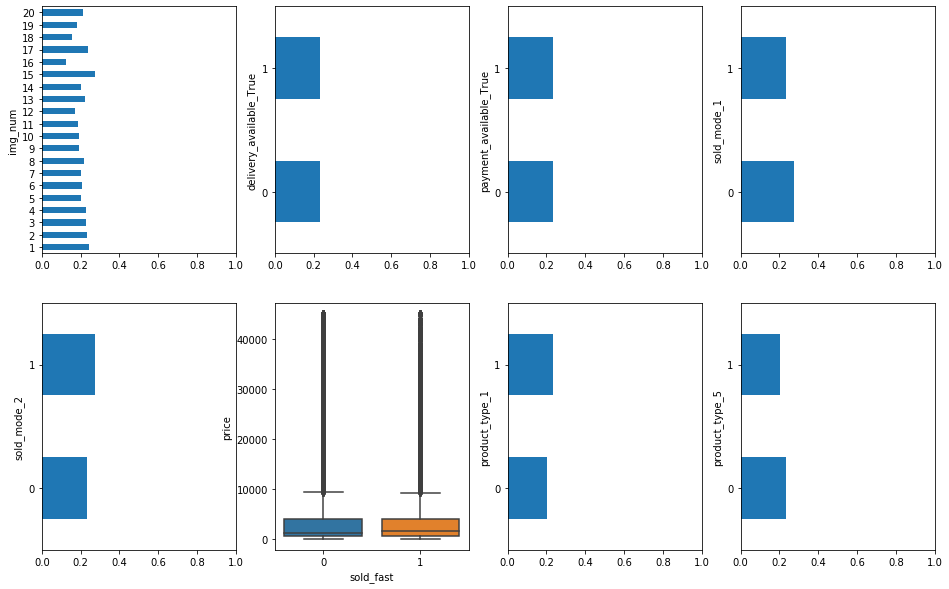

In [11]:
figbi, axesbi = plt.subplots(2, 4, figsize=(16, 10))
data.groupby('img_num')['sold_fast'].mean().plot(kind='barh',ax=axesbi[0,0],xlim=[0,1])
data.groupby('delivery_available_True')['sold_fast'].mean().plot(kind='barh',ax=axesbi[0,1],xlim=[0,1])
data.groupby('payment_available_True')['sold_fast'].mean().plot(kind='barh',ax=axesbi[0,2],xlim=[0,1])
data.groupby('sold_mode_1')['sold_fast'].mean().plot(kind='barh',ax=axesbi[0,3],xlim=[0,1])
data.groupby('sold_mode_2')['sold_fast'].mean().plot(kind='barh',ax=axesbi[1,0],xlim=[0,1])
data.groupby('product_type_1')['sold_fast'].mean().plot(kind='barh',ax=axesbi[1,2],xlim=[0,1])
data.groupby('product_type_5')['sold_fast'].mean().plot(kind='barh',ax=axesbi[1,3],xlim=[0,1])
sns.boxplot(x="sold_fast", y="price", data=data, ax=axesbi[1,1])

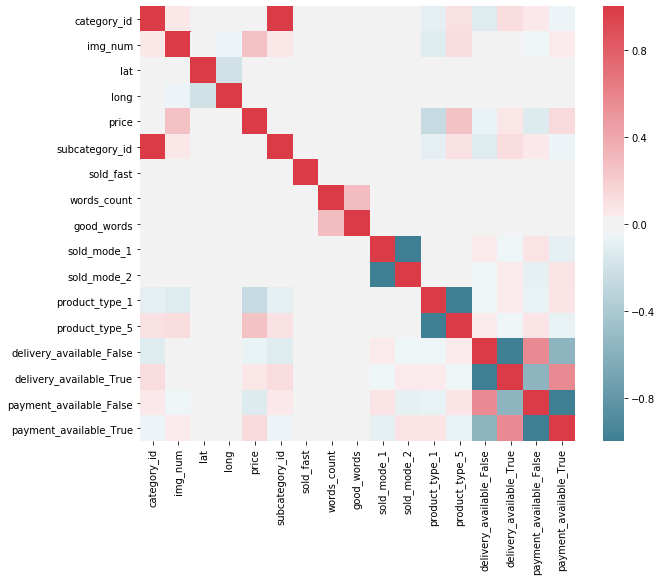

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

In [13]:
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(normalize=True, alpha=0.01, fit_intercept = True)
model_ridge.fit(X_train, y_train)
predict = model_ridge.predict(X_test)
predictions = [round(value) for value in predict]
print("ACCURACY = {}".format(accuracy_score(y_test, predictions)))
print("ROC-AUC = {}".format(roc_auc_score(y_test, predict)))

ACCURACY = 0.7667879783986852
ROC-AUC = 0.5983629625471771


In [16]:
scale_pos_weight = 3

def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    weights = np.where(labels == 1.0, scale_pos_weight, 1.0)
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad * weights, hess * weights

dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

param = {'max_depth': 4, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic', 'seed': 32}
param['nthread'] = 4
param['eval_metric'] = 'auc'

num_round = 200
xg_model = xgb.train(param, dtrain, num_round, obj=logregobj)

xg_predict = xg_model.predict(dtest)

predictions = [round(value) for value in xg_predict]
print("ACCURACY = {}".format(accuracy_score(y_test, predictions)))
print("ROC-AUC = {}".format(roc_auc_score(y_test, xg_predict)))

/home/irakliy01/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


ACCURACY = 0.6186017844564452
ROC-AUC = 0.6003455005439422


In [17]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', max_depth = 6, random_state=42, eta=0, min_child_weight = 1, silent=1, nthread=4, eval_metric='mlogloss', max_delta_step = 4)
xg_reg.fit(X_train, y_train)
xg_reg_predict = xg_reg.predict(X_test)
predictions = [round(value) for value in xg_reg_predict]
print("ACCURACY = {}".format(accuracy_score(y_test, predictions)))
print("ROC-AUC = {}".format(roc_auc_score(y_test, xg_reg_predict)))

/home/irakliy01/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


ACCURACY = 0.7671206073413164
ROC-AUC = 0.616868774973297


# Model interpretation
Try to точности interpret your modrevealel results
* What **knowledge** does it reveal?

Наша модель верно предсказывает покупку продукта в течение трех дней с вероятностью 62%, что, несомненно, лучше, чем 50%, когда модель *угадывает* результат. На основе входных параметров при помощи этой модели можно предугадать, купит ли клиент товар в течение трех дней. Количество верных предсказаний будет больше, чем неверных. К сожалению, исходя из таблицы корреляции, почти никакой параметр не коррелирует с целевым, что усложняет предсказание. Тем ни менее, правильно обработав данные, мы достигли AUC - 62%.